# Real-Time Monitoring of DoS Attacks: Analyse Data of RSDoS Crawler

This notebook runs a very first analysis as part of the real-time monitoring of DoS attacks. The aim of this analysis is to get some first insights into the data of the RSDoS crawler.

*Stefan Scholz* 
*2020-07-30*

In [1]:
import os
import json
import gzip
import pprint
import itertools
import pandas as pd
from datetime import datetime

## Data Preparation

In [2]:
# get dumps
dumps_dir = "../data/"
dumps = [os.path.join(dumps_dir, file) for file in os.listdir(dumps_dir) if file.endswith(".json.gz")]
print(dumps)

['../data/data-telescope-crawler-dos-202007301100.json.gz', '../data/data-telescope-crawler-dos-202007301800.json.gz', '../data/data-telescope-crawler-dos-202007301300.json.gz', '../data/data-telescope-crawler-dos-202007301400.json.gz', '../data/data-telescope-crawler-dos-202007301200.json.gz', '../data/data-telescope-crawler-dos-202007301600.json.gz', '../data/data-telescope-crawler-dos-202007301700.json.gz', '../data/data-telescope-crawler-dos-202007301900.json.gz', '../data/data-telescope-crawler-dos-202007301500.json.gz']


In [3]:
def date_parser(value):
    """
    Parse dates in dump
    """
    
    if isinstance(value, dict):
        for k, v in value.items():
            value[k] = date_parser(v)
    elif isinstance(value, list):
        for index, row in enumerate(value):
            value[index] = date_parser(row)
    elif isinstance(value, str) and value:
        try:
            value = datetime.strptime(value, "%Y-%m-%dT%H:%M:%S.%f%z")
        except (ValueError, AttributeError):
            pass
    return value

# get attacks
attacks = [json.load(gzip.open(dump, "rt", encoding="utf-8"), object_hook=date_parser)["attacks"] for dump in dumps]
attacks = list(itertools.chain.from_iterable(attacks))
attacks = pd.DataFrame(attacks)

## Data Analysis

### Attacks

In [4]:
# get number attacks
print(len(attacks.index))

1420


In [5]:
# get time window of start times
print(attacks.start_time.min())
print(attacks.start_time.max())

2020-07-17 21:51:42.222120+00:00
2020-07-30 16:57:25.728460+00:00


<AxesSubplot:title={'center':'Number of started attacks per hour'}, xlabel='start_time'>

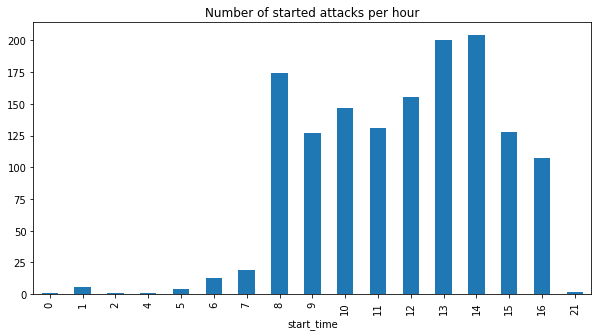

In [6]:
# get number of started attacks over time
start_times = pd.to_datetime(attacks.start_time)
attacks.ip.groupby([start_times.dt.hour]).count().plot(kind="bar", figsize=(10,5), title="Number of started attacks per hour")

In [7]:
# get time window of latest times
print(attacks.latest_time.min())
print(attacks.latest_time.max())

2020-07-30 08:01:41.135356+00:00
2020-07-30 16:59:58.207574+00:00


<AxesSubplot:title={'center':'Number of finished attacks per hour'}, xlabel='latest_time'>

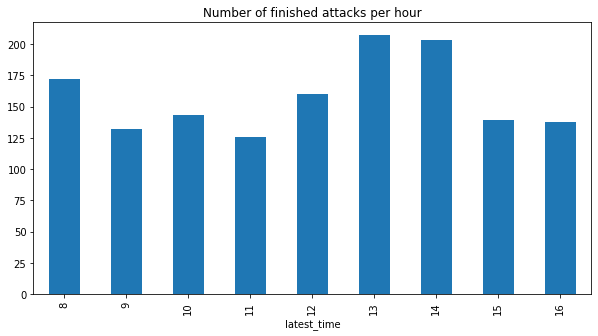

In [8]:
# get number of finished attacks over time
latest_times = pd.to_datetime(attacks.latest_time)
attacks.ip.groupby([latest_times.dt.hour]).count().plot(kind="bar", figsize=(10,5), title="Number of finished attacks per hour")

In [9]:
# get duration of attacks
durations = attacks.latest_time - attacks.start_time
durations.describe()

count                         1420
mean     0 days 01:51:25.982792244
std      0 days 19:06:41.216080131
min         0 days 00:01:00.015651
25%      0 days 00:01:48.003803250
50%         0 days 00:04:08.586669
75%      0 days 00:12:17.527106500
max        12 days 10:50:44.388981
dtype: object

<AxesSubplot:title={'center':'Duration of attacks in minutes'}, ylabel='Frequency'>

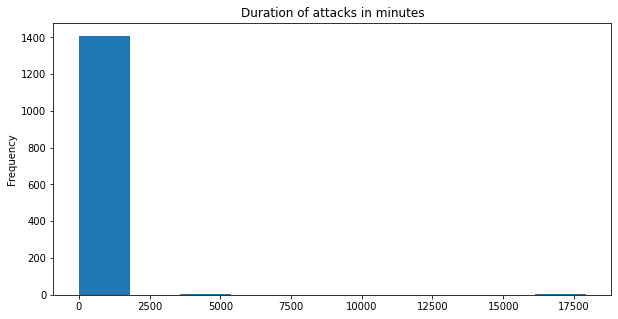

In [10]:
# get duration of attacks
durations = attacks.latest_time - attacks.start_time
durations.astype("timedelta64[m]").plot.hist(figsize=(10,5), title="Duration of attacks in minutes")

In [11]:
# get number of attack vectors per attack
attack_vectors = attacks.attack_vectors.apply(lambda attack_vectors: len(attack_vectors))
attack_vectors.describe()

count    1420.000000
mean        2.366197
std         3.901679
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        54.000000
Name: attack_vectors, dtype: float64

<AxesSubplot:title={'center':'Number of attack vectors per attack'}, ylabel='Frequency'>

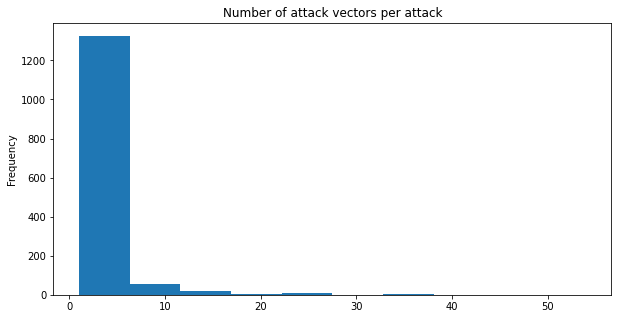

In [12]:
# get number of attack vectors per attack
attack_vectors = attacks.attack_vectors.apply(lambda attack_vectors: len(attack_vectors))
attack_vectors.plot.hist(figsize=(10,5), title="Number of attack vectors per attack")

<AxesSubplot:title={'center':'Time difference between latest time of previous attack vector and start time of next attack vector within attacks in minutes'}, ylabel='Frequency'>

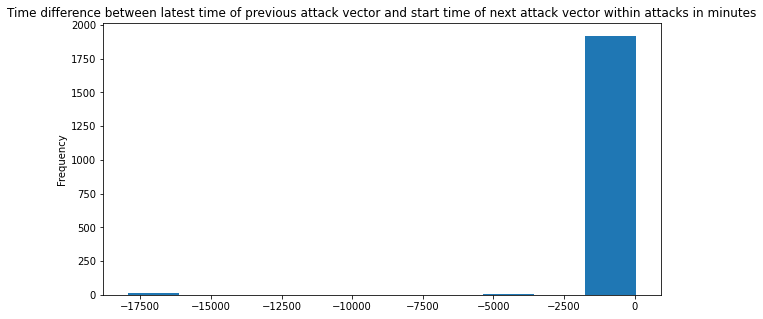

In [13]:
# get time difference between target lines within attack which got merged
differences_within = attacks.attack_vectors.apply(lambda attack_vectors: [next_vector["start_time"] - previous_vector["latest_time"] for previous_vector, next_vector in zip(attack_vectors, attack_vectors[1:])]).explode()
differences_within.astype("timedelta64[m]").plot.hist(figsize=(10,5), title="Time difference between latest time of previous attack vector and start time of next attack vector within attacks in minutes")

### Targets

In [14]:
# get number distinct targets
print(len(attacks.ip.unique()))

968


<AxesSubplot:title={'center':'Number of attacks on same target'}, ylabel='Frequency'>

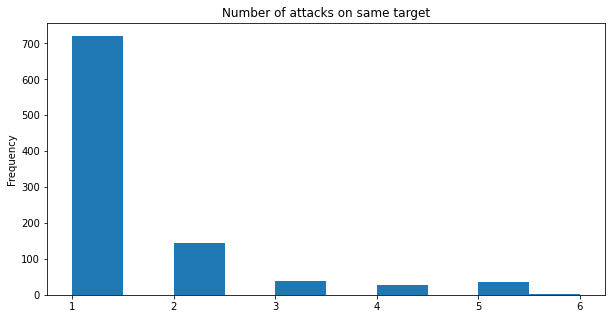

In [15]:
# get number of attacks on same target
attacks.ip.groupby([attacks.ip]).count().plot.hist(figsize=(10,5), title="Number of attacks on same target")

In [16]:
# get time difference between attacks which did not get merged
attacks.sort_values(by=["start_time"], ascending=True, inplace=True)
differences_across = attacks.groupby(attacks.ip).apply(lambda group: [next_target[1]["start_time"] - previous_target[1]["latest_time"] for previous_target, next_target in zip(list(group.iterrows()), list(group.iterrows())[1:])]).explode()
differences_across.astype("timedelta64[m]").describe()

count     452.000000
mean      113.298673
std       258.564864
min     -5078.000000
25%        77.750000
50%       107.000000
75%       120.000000
max       480.000000
dtype: float64

<AxesSubplot:title={'center':'Time difference between latest time of previous attack and start time of next attack across equal targets in minutes'}, ylabel='Frequency'>

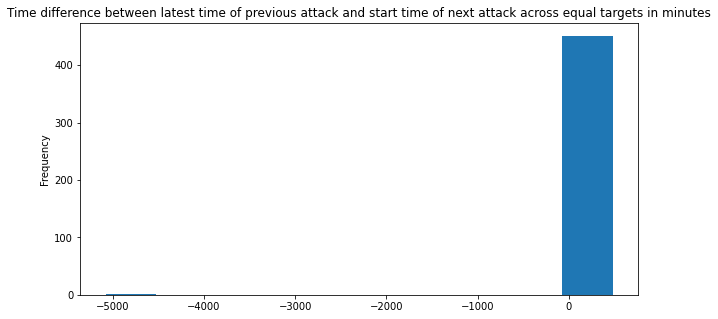

In [17]:
# get time difference between attacks which did not get merged
differences_across.astype("timedelta64[m]").plot.hist(figsize=(10,5), title="Time difference between latest time of previous attack and start time of next attack across equal targets in minutes")

### Hosts

In [18]:
# get number of hosts
hosts = attacks.hosts
print(len(hosts.explode().index))

2208


In [19]:
# get number of distinct hosts
print(len(hosts.explode().unique()))

1495


<AxesSubplot:title={'center':'Number of hosts per attack'}, ylabel='Frequency'>

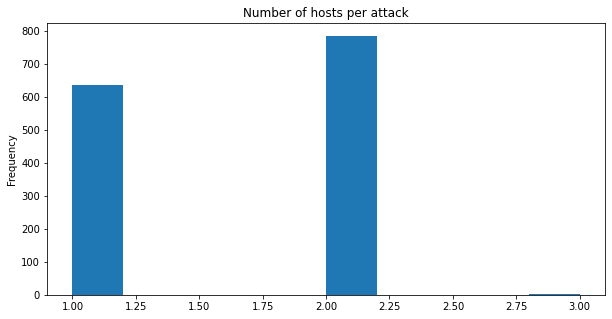

In [20]:
# get number of hosts per attack
hosts.apply(lambda hosts: len(hosts)).plot.hist(figsize=(10,5), title="Number of hosts per attack")

### Crawls

In [21]:
# get number of crawls
crawls = attacks.crawls
print(len(crawls.explode().dropna()))

24413


In [22]:
# get number of crawls with status code
print(crawls.explode().dropna().apply(lambda crawl: crawl["status"]).value_counts())

-1      19998
 200     1978
 404     1001
 400      660
 403      617
 429       46
 500       44
 503       36
 502       21
 414       10
 302        2
Name: crawls, dtype: int64


In [23]:
# get number of distinct crawls
print(len(crawls.explode().dropna().apply(lambda crawl: crawl["record"]).unique()))

24159


In [24]:
# get number of crawls per attack
crawls.apply(lambda crawls: len(crawls)).describe()

count    1420.000000
mean       17.192254
std        18.502890
min         2.000000
25%         8.000000
50%        12.000000
75%        22.250000
max       230.000000
Name: crawls, dtype: float64

<AxesSubplot:title={'center':'Number of crawls per attack'}, ylabel='Frequency'>

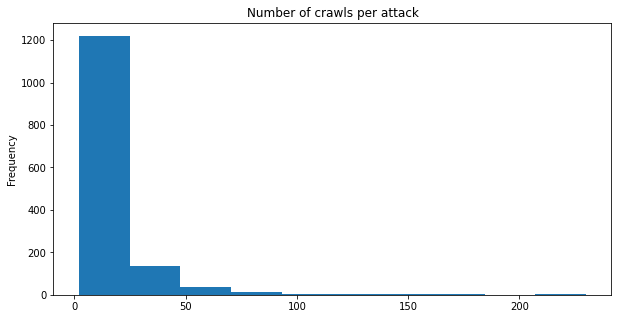

In [25]:
# get number of crawls per attack
crawls.apply(lambda crawls: len(crawls)).plot.hist(figsize=(10,5), title="Number of crawls per attack")